In [1]:
import sys
import os
import numpy as np
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import metpy.calc as mpc
from metpy.units import units
# for animations
from PIL import Image

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# aggregation indices
os.chdir('/w2-data2/willytsai/python_module')
import conorgidx_revise as agi
from SCAI_calc4obj import labeled_obj, SCAI_calc
from COP_calc4obj import COP
from MICA_calc4obj import MICA

In [4]:
def running_mean(y,window_N):
    y_avg = np.zeros(len(y))
    avg_mask = np.ones(window_N) / window_N

    y_avg = np.convolve(y, avg_mask, 'same')
    y_avg[-window_N:] = y[-window_N:]
    y_avg[:window_N] = y[:window_N]
    return y_avg    

In [5]:
def read_data(data_dir,t_start=0,t_end=721):
    
    os.chdir(data_dir)
    print(data_dir)
    file_name = glob('*nc')
    data_zon = xr.open_dataset('cm1out_zonmean.nc')
#    data_3d = xr.open_dataset('cm1out_sub3d.nc')
    data_2d = xr.open_dataset('cm1out_2Dvars.nc')
    
    # 3d data
#    th3d = data_3d.th[t_start:t_end,:30,:,:]
#    v3d = data_3d.vinterp[t_start:t_end,:30,:,:]
#    u3d = data_3d.uinterp[t_start:t_end,:30,:,:]
    
    # zonal mean data
    th = data_zon.th[t_start:t_end,:,:,:]
    qv = data_zon.qv[t_start:t_end,:,:,:]
    u = data_zon.uinterp[t_start:t_end,:,:,:]
    v = data_zon.vinterp[t_start:t_end,:,:,:]
    w = data_zon.winterp[t_start:t_end,:,:,:]
    qc = data_zon.qc[t_start:t_end,:,:,:]
    qi = data_zon.qi[t_start:t_end,:,:,:]
    prs = data_zon.prs[t_start:t_end,:,:,:]
    # 2d data
    prate = data_2d.prate[t_start:t_end,:,:]
    pwat = data_2d.pwat[t_start:t_end,:,:]
    cwp = data_2d.cwp[t_start:t_end,:,:]
    cape = data_2d.cape[t_start:t_end,:,:]
    cin = data_2d.cin[t_start:t_end,:,:]
    
    # temperature conversion
    T = th/((1000*100/prs)**(287.15/1004))-273.15 # [degC]
    # density 
    ro = prs/(287.15*(T+273.15))

    x_dim = data_2d.lon
    y_dim = data_2d.lat
    div = np.gradient(v,y_dim*1000,axis=2) # du/dx+dv/dy 
    vor = -np.gradient(u,y_dim*1000,axis=2) # -du/dy+dv/dx
    #relative humidty calculation, Buck (1996)
    es_liq = 0.61121*np.exp((18.678-T/234.5)*(T/(257.14+T)))*10 #[hpa]
    es_ice = 0.61115*np.exp((23.036-T/333.7)*(T/(279.82+T)))*10

    qs_liq = 0.622*es_liq/(prs/100-es_liq)
    qs_ice = 0.622*es_ice/(prs/100-es_ice)

    rh = qv/qs_liq
    rh_ice = qv/qs_ice

    rh = rh.values.flatten()
    rh_ice = rh_ice.values.flatten()
    T_test = T.values.flatten()

    rh[T_test<0] = rh_ice[T_test<0]
    rh = rh.reshape((T.shape[0],T.shape[1],T.shape[2],T.shape[3]))
    rh = xr.DataArray(rh,coords=[T.time,T.lev,T.lat,T.lon],dims=['time','lev','lat','lon'])
    
#    return (th,T,qv,qc,qi,rh,prate*3600*24,pwat*1000,cwp,u,v,w,div,vor,cape,cin,prs,ro,th3d,v3d,u3d)
    return (th,T,qv,qc,qi,rh,prate*3600*24,pwat*1000,cwp,u,v,w,div,vor,cape,cin,prs,ro)

In [7]:
# get weather or weather2 
server = '/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne/'
exp_name = 'CM1_RAD4K_MPI_SFXUNI_Midshear_2'
os.chdir(server + exp_name)
os.system('mkdir -p fig') # create a figure archive
fig_dir = server+'/'+exp_name+'/fig/' 

In [8]:
(th1,T1,qv1,qc1,qi1,rh1,prate1,pwat1,cwp1,u1,v1,w1,div1,vor1,cape1,cin1,prs1,ro1) = read_data(server+exp_name
                                                                                     ,t_start=0,t_end=2881)

/w2-data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_MPI_SFXUNI_Midshear_2


In [9]:
# data = xr.open_dataset('cm1out_SFX.nc') 
# qfx = data.qfx*2.5e6
# hfx = data.hfx
# tfx = qfx+hfx

data = xr.open_dataset('cm1out_qvbgt_dm.nc')
qvb_hadv = data.qvb_hadv[-72:,:,:,:].squeeze()
qvb_vadv = data.qvb_vadv[-72:,:,:,:].squeeze()
qvb_hidiff = data.qvb_hidiff[-72:,:,:,:].squeeze()
qvb_vidiff = data.qvb_vidiff[-72:,:,:,:].squeeze()
qvb_hturb = data.qvb_hturb[-72:,:,:,:].squeeze()
qvb_vturb = data.qvb_vturb[-72,:,:,:].squeeze()
qvb_mp = data.qvb_mp[-72:,:,:,:].squeeze()
qt_cond = data.qt_cond[-72:,:,:,:].squeeze()
qt_evac = data.qt_evac[-72:,:,:,:].squeeze()
qt_evar = data.qt_evar[-72:,:,:,:].squeeze()
qt_dep = data.qt_dep[-72:,:,:,:].squeeze()
qt_subl = data.qt_subl[-72:,:,:,:].squeeze()

z_dim = data.lev*1000

In [11]:
# scatter plot for delta_P and delta_THF
# plt.scatter(tfx[-1,:,:]-tfx[-1,:,:].mean(['lon','lat']),
#             2.5e6/86400*prate1[-1,:,:]-2.5e6/86400*prate1[-1,:,:].mean(['lon','lat']))

In [12]:
ro = ro1[-360:,:,:,0].mean(['time','lat'])
#ro = np.tile(ro,[120,120,1]).swapaxes(2,0)

In [12]:
# vint_qvb_hadv = np.trapz(ro*qvb_hadv,z_dim,axis=0).mean()*2.5e6 # [W/m^2]
# vint_qvb_vadv = np.trapz(ro*qvb_vadv,z_dim,axis=0).mean()*2.5e6
# vint_qvb_hturb = np.trapz(ro*qvb_hturb,z_dim,axis=0).mean()*2.5e6
# vint_qvb_vturb = np.trapz(ro*qvb_vturb,z_dim,axis=0).mean()*2.5e6
# vint_qvb_mp = np.trapz(ro*qvb_mp,z_dim,axis=0).mean()*2.5e6
# vint_qt_cond = np.trapz(ro*qt_cond,z_dim,axis=0).mean()*2.5e6
# vint_qt_evac = np.trapz(ro*qt_evac,z_dim,axis=0).mean()*2.5e6
# vint_qt_evar = np.trapz(ro*qt_evar,z_dim,axis=0).mean()*2.5e6
# vint_qt_dep = np.trapz(ro*qt_dep,z_dim,axis=0).mean()*2.5e6

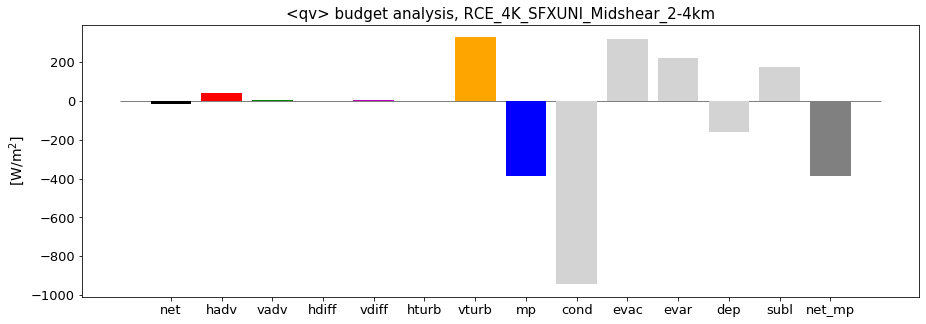

In [14]:
vint_qvb_hadv = np.trapz(ro*qvb_hadv,z_dim,axis=0).mean()*2.5e6 # [W/m^2]
vint_qvb_vadv = np.trapz(ro*qvb_vadv,z_dim,axis=0).mean()*2.5e6
vint_qvb_hidiff = np.trapz(ro*qvb_hidiff,z_dim,axis=0).mean()*2.5e6
vint_qvb_vidiff = np.trapz(ro*qvb_vidiff,z_dim,axis=0).mean()*2.5e6
vint_qvb_hturb = np.trapz(ro*qvb_hturb,z_dim,axis=0).mean()*2.5e6
vint_qvb_vturb = np.trapz(ro*qvb_vturb,z_dim,axis=0).mean()*2.5e6
vint_qvb_mp = np.trapz(ro*qvb_mp,z_dim,axis=0).mean()*2.5e6
vint_qt_cond = np.trapz(ro*qt_cond,z_dim,axis=0).mean()*2.5e6
vint_qt_evac = np.trapz(ro*qt_evac,z_dim,axis=0).mean()*2.5e6
vint_qt_evar = np.trapz(ro*qt_evar,z_dim,axis=0).mean()*2.5e6
vint_qt_dep = np.trapz(ro*qt_dep,z_dim,axis=0).mean()*2.5e6
vint_qt_subl = np.trapz(ro*qt_subl,z_dim,axis=0).mean()*2.5e6

net = vint_qvb_hadv + vint_qvb_vadv + vint_qvb_hturb + vint_qvb_vturb + \
      vint_qvb_mp # net qv tendency 
net_mp = vint_qt_cond + vint_qt_evac + vint_qt_evar + vint_qt_dep + vint_qt_subl

cbar = ['k','r','g','b','m','y','orange','b','lightgrey'
        ,'lightgrey','lightgrey','lightgrey','lightgrey','grey']

fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.bar(['net','hadv','vadv','hdiff','vdiff','hturb','vturb','mp'
        ,'cond','evac','evar','dep','subl','net_mp']
       
        ,[net,vint_qvb_hadv,vint_qvb_vadv,vint_qvb_hidiff,vint_qvb_vidiff
         ,vint_qvb_hturb,vint_qvb_vturb,vint_qvb_mp
         ,vint_qt_cond,vint_qt_evac,vint_qt_evar,vint_qt_dep,vint_qt_subl,net_mp],
        color=cbar)
ax.set_ylabel('[W/m$^2$]',fontsize=14);
ax.hlines(0,xmin=-1,xmax=14,linewidth=0.5,zorder=1)
ax.set_title('<qv> budget analysis, RCE_4K_SFXUNI_Midshear_2-4km',fontsize=15)
ax.tick_params(labelsize=13)
fig.savefig(fig_dir+'qvbudget_component.pdf',bbox_inches='tight',transparent=False)

In [15]:
th1.shape

(999, 65, 120, 1)

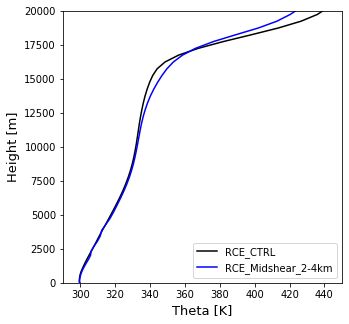

In [24]:
# T profiles
fig = plt.figure(figsize=(5,5))

plt.plot(th1[0,:,:,0].mean(axis=(1)),z_dim,'k',label='RCE_CTRL')
plt.plot(th1[-360:,:,:,0].mean(axis=(0,2)),z_dim,'b',label='RCE_Midshear_2-4km')
plt.ylim([0,20000])
plt.xlim([290,450])
plt.ylabel('Height [m]',fontsize=13)
plt.xlabel('Theta [K]',fontsize=13)
plt.legend()
fig.savefig(fig_dir+'theta_profile.pdf',bbox_inches='tight',transparent=False)

In [ ]:
test = np.copy(qvb_vturb[:,:,:].mean(axis=(1,2)))
test[test<0] = 0
#test = np.trapz(ro*test,z_dim)

In [ ]:
test.shape

In [ ]:
# vturb --> SFX 

plt.plot(2.5e6*ro*qvb_vturb[:,:,:].mean(axis=(1,2)),z_dim,'ok')
plt.plot(2.5e6*test,z_dim,'-b')
plt.ylim([0,2000])
plt.ylim([0,2000])

print(vint_qvb_vturb)
print(2.5e6*np.trapz(ro*test,z_dim))